<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.set_style("whitegrid", {'axes.grid' : False})

from tqdm.auto import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [5]:
from pytorch_metric_learning import losses, miners, distances, reducers, samplers
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn as nn
import random
import lightgbm as lgb

In [6]:
from code.dataloader import AgeGroupMLDataset, AgeGroupClfDataset
from code.encoder_gru import Encoder
from code.decoder import Decoder
from code.classifier import Classifier
from code.utils import train_ml_model, train_classifier

In [7]:
BATCH_SIZE = 64 # BATCH_SIZE unique persons
NUM_OF_SUBSEQUENCES = 5
SUBSEQUENCE_LENGTH = 90

EMBEDDING_DIM = 256
LR = 0.002
NUM_EPOCHS = 50

cat_vocab_sizes = [204]
cat_embedding_dim = 102
num_input_dim = 4
NUM_OBS = 30000

In [ ]:
arches = (
    ('GRU', nn.GRU(
                num_input_dim + cat_embedding_dim,
                EMBEDDING_DIM,
                batch_first=False),
    ),
    ('LSTM', nn.LSTM(
                num_input_dim + cat_embedding_dim,
                EMBEDDING_DIM,
                batch_first=False),
    ),
)

In [ ]:
dataset = AgeGroupMLDataset(num_observations=NUM_OBS)

In [ ]:
dataset.load_client_to_indices()

In [ ]:
clfdataset = AgeGroupClfDataset()

In [ ]:
clfdataset.load_client_to_indices()

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [ ]:
targets = dataset.targets

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE,
    num_workers=0,
)

targets = clfdataset.targets

train_idx, test_idx= train_test_split(
    np.arange(len(targets)),
    test_size=0.3,
    shuffle=True,
    stratify=targets,
    random_state=228
)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

trainloader = torch.utils.data.DataLoader(
    clfdataset, batch_size=BATCH_SIZE,
    sampler=train_sampler)
testloader = torch.utils.data.DataLoader(
    clfdataset, batch_size=BATCH_SIZE,
    sampler=test_sampler)

In [ ]:
for (arch, cell) in tqdm(arches):
    print(arch)
    LR = 0.002
    
    # train decoder
    
    encoder = Encoder(
        numerical_input_dim=num_input_dim,
        cat_vocab_sizes=cat_vocab_sizes,
        cat_embedding_dim=cat_embedding_dim,
        embedding_dim=EMBEDDING_DIM,
    )
    encoder.sequence_encoder = cell
    encoder.to(device);
    optimizer = optim.Adam(encoder.parameters(), lr=LR)
    
    distance = distances.CosineSimilarity()
    reducer = reducers.ThresholdReducer(low = 0) # basically, returns average
    loss_func = losses.TripletMarginLoss(margin = 0.4, distance = distance, reducer = reducer)
    mining_func = miners.TripletMarginMiner(margin = 0.4, distance = distance, type_of_triplets = "semihard")
    
    train_losses = train_ml_model(
        encoder, NUM_EPOCHS, dataloader, NUM_OF_SUBSEQUENCES,
        mining_func, loss_func, optimizer)
    fig, axs = plt.subplots(figsize=(12, 6))

    plt.plot(train_losses, label='train')
    plt.xlabel('iter')
    plt.ylabel('loss');
    plt.savefig(f'plots/ML_{arch}_{EMBEDDING_DIM}_{NUM_OBS}_{NUM_EPOCHS}.png')
    
    SCHEDULER_EPOCHS = 2
    LR = 0.002
    
    # train classifier decoder
    
    classifier = Classifier(
        numerical_input_dim=num_input_dim,
        cat_vocab_sizes=cat_vocab_sizes,
        cat_embedding_dim=cat_embedding_dim,
        embedding_dim=EMBEDDING_DIM
    )
    classifier.encoder = encoder
    classifier.freeze_encoder()
    classifier.to(device);
    
    optimizer = optim.Adam(classifier.decoder.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=SCHEDULER_EPOCHS,
    )
    
    train_losses, train_accuracy, val_losses, val_accuracy = train_classifier(
        classifier, NUM_EPOCHS, trainloader, testloader,
        optimizer, criterion, scheduler,
        enable_train_mode = lambda: classifier.decoder.train(),
        enable_test_mode = lambda: classifier.decoder.eval(),
    )
    
    fig, axs = plt.subplots(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='validation')
    plt.xlabel('iter')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel('iter')
    plt.ylabel('accuracy');
    plt.plot(train_accuracy, label='train')
    plt.plot(val_accuracy, label='validation')
    plt.legend()

    plt.savefig(f'plots/clfdec_{arch}_{EMBEDDING_DIM}_{NUM_OBS}_{NUM_EPOCHS}.png')

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache() 

In [ ]:
arch = 'GRU'

dims = [32, 64, 128, 256, 512, 1024]
accs = []

for EMBEDDING_DIM in tqdm(dims):
    print(EMBEDDING_DIM)
    LR = 0.002
    
    # train decoder
    
    encoder = Encoder(
        numerical_input_dim=num_input_dim,
        cat_vocab_sizes=cat_vocab_sizes,
        cat_embedding_dim=cat_embedding_dim,
        embedding_dim=EMBEDDING_DIM,
    )
    encoder.to(device);
    encoder.train()
    optimizer = optim.Adam(encoder.parameters(), lr=LR)
    
    distance = distances.CosineSimilarity()
    reducer = reducers.ThresholdReducer(low = 0) # basically, returns average
    loss_func = losses.TripletMarginLoss(margin = 0.4, distance = distance, reducer = reducer)
    mining_func = miners.TripletMarginMiner(margin = 0.4, distance = distance, type_of_triplets = "semihard")
    
    train_losses = train_ml_model(
        encoder, NUM_EPOCHS, dataloader, NUM_OF_SUBSEQUENCES,
        mining_func, loss_func, optimizer)
    fig, axs = plt.subplots(figsize=(12, 6))

    plt.plot(train_losses, label='train')
    plt.xlabel('iter')
    plt.ylabel('loss');
    plt.savefig(f'plots/ML_{arch}_{EMBEDDING_DIM}_{NUM_OBS}_{NUM_EPOCHS}.png')
    
    SCHEDULER_EPOCHS = 2
    LR = 0.002
    
    # train classifier decoder
    
    classifier = Classifier(
        numerical_input_dim=num_input_dim,
        cat_vocab_sizes=cat_vocab_sizes,
        cat_embedding_dim=cat_embedding_dim,
        embedding_dim=EMBEDDING_DIM
    )
    classifier.encoder = encoder
    classifier.freeze_encoder()
    classifier.to(device);
    
    optimizer = optim.Adam(classifier.decoder.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=SCHEDULER_EPOCHS,
    )
    
    train_losses, train_accuracy, val_losses, val_accuracy = train_classifier(
        classifier, NUM_EPOCHS, trainloader, testloader,
        optimizer, criterion, scheduler,
        enable_train_mode = lambda: classifier.decoder.train(),
        enable_test_mode = lambda: classifier.decoder.eval(),
    )
    
    fig, axs = plt.subplots(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='validation')
    plt.xlabel('iter')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel('iter')
    plt.ylabel('accuracy');
    plt.plot(train_accuracy, label='train')
    plt.plot(val_accuracy, label='validation')
    plt.legend()

    plt.savefig(f'plots/clfdec_{arch}_{EMBEDDING_DIM}_{NUM_OBS}_{NUM_EPOCHS}.png')
    
    accs.append(val_accuracy[-1])

In [9]:
dataset = AgeGroupMLDataset()
dataset.load_client_to_indices()
clfdataset = AgeGroupClfDataset()
clfdataset.load_client_to_indices()

0it [00:00, ?it/s]

21600 50


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 Loss = 0.1794039011001587
Epoch 1 Loss = 0.15074722468852997
Epoch 2 Loss = 0.14555928111076355
Epoch 3 Loss = 0.14291152358055115
Epoch 4 Loss = 0.14169228076934814
Epoch 5 Loss = 0.14104348421096802
Epoch 6 Loss = 0.14002077281475067
Epoch 7 Loss = 0.13917864859104156
Epoch 8 Loss = 0.1386980414390564
Epoch 9 Loss = 0.13827677071094513
Epoch 10 Loss = 0.1375150829553604
Epoch 11 Loss = 0.13773338496685028
Epoch 12 Loss = 0.13700979948043823
Epoch 13 Loss = 0.13684403896331787
Epoch 14 Loss = 0.1366080939769745
Epoch 15 Loss = 0.136012002825737
Epoch 16 Loss = 0.1358441561460495
Epoch 17 Loss = 0.1354147493839264
Epoch 18 Loss = 0.1351713091135025
Epoch 19 Loss = 0.13523460924625397
Epoch 20 Loss = 0.1349911242723465
Epoch 21 Loss = 0.13470108807086945
Epoch 22 Loss = 0.13463659584522247
Epoch 23 Loss = 0.1342047154903412
Epoch 24 Loss = 0.13389411568641663
Epoch 25 Loss = 0.13366974890232086
Epoch 26 Loss = 0.13343246281147003
Epoch 27 Loss = 0.13354846835136414
Epoch 28 Loss

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0, train acc: 0.5141534209251404, val acc: 0.51712965965271
train loss: 1.0715402364730835; val loss: 1.0266178846359253
Epoch 1, train acc: 0.529629647731781, val acc: 0.5291666984558105
train loss: 1.0279675722122192; val loss: 1.0216423273086548
Epoch 2, train acc: 0.5292328000068665, val acc: 0.5325617790222168
train loss: 1.0246152877807617; val loss: 1.0154000520706177
Epoch 3, train acc: 0.533134937286377, val acc: 0.542129635810852
train loss: 1.0160508155822754; val loss: 1.0094109773635864
Epoch 4, train acc: 0.5361111164093018, val acc: 0.5291666984558105
train loss: 1.0167348384857178; val loss: 1.0166096687316895
Epoch 5, train acc: 0.5343254208564758, val acc: 0.5358024835586548
train loss: 1.0124754905700684; val loss: 1.009969711303711
Epoch 6, train acc: 0.537169337272644, val acc: 0.529938280582428
train loss: 1.0080251693725586; val loss: 1.0311295986175537
Epoch 7, train acc: 0.5410714149475098, val acc: 0.5354938507080078
train loss: 1.0016863346099854; val l

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 0 Loss = 0.19240325689315796
Epoch 1 Loss = 0.16456978023052216
Epoch 2 Loss = 0.15005840361118317
Epoch 3 Loss = 0.1467064917087555
Epoch 4 Loss = 0.14388300478458405
Epoch 5 Loss = 0.1420990377664566
Epoch 6 Loss = 0.14076483249664307
Epoch 7 Loss = 0.13993990421295166
Epoch 8 Loss = 0.1387360841035843
Epoch 9 Loss = 0.13844554126262665
Epoch 10 Loss = 0.13774092495441437
Epoch 11 Loss = 0.13788104057312012
Epoch 12 Loss = 0.13693271577358246
Epoch 13 Loss = 0.13616254925727844
Epoch 14 Loss = 0.13534846901893616
Epoch 15 Loss = 0.13531386852264404
Epoch 16 Loss = 0.13487206399440765
Epoch 17 Loss = 0.13443410396575928
Epoch 18 Loss = 0.13383324444293976
Epoch 19 Loss = 0.13411910831928253
Epoch 20 Loss = 0.1333518773317337
Epoch 21 Loss = 0.13337302207946777
Epoch 22 Loss = 0.13343925774097443
Epoch 23 Loss = 0.1325405240058899
Epoch 24 Loss = 0.13208754360675812
Epoch 25 Loss = 0.13219983875751495
Epoch 26 Loss = 0.1322009265422821
Epoch 27 Loss = 0.13219067454338074
Epoch 28

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch 0, train acc: 0.5026454925537109, val acc: 0.5370370745658875
train loss: 1.154313564300537; val loss: 1.0392876863479614
Epoch 1, train acc: 0.5416666865348816, val acc: 0.5484567880630493
train loss: 1.0351898670196533; val loss: 0.9899078607559204
Epoch 2, train acc: 0.5403439402580261, val acc: 0.5308642387390137
train loss: 0.9958013296127319; val loss: 0.9860106706619263
Epoch 3, train acc: 0.5458994507789612, val acc: 0.5558642148971558
train loss: 0.981446385383606; val loss: 0.9597638249397278
Epoch 4, train acc: 0.5587301850318909, val acc: 0.5422839522361755
train loss: 0.9714844822883606; val loss: 0.9656231999397278
Epoch 5, train acc: 0.5547618865966797, val acc: 0.5373457074165344
train loss: 0.9655737280845642; val loss: 0.9659120440483093
Epoch 6, train acc: 0.5468254089355469, val acc: 0.5577160716056824
train loss: 0.9640181064605713; val loss: 0.957409679889679
Epoch 7, train acc: 0.5525132417678833, val acc: 0.5623456835746765
train loss: 0.9562300443649292; 

Epoch 64, train acc: 0.5625661611557007, val acc: 0.5385802984237671
train loss: 0.9357146620750427; val loss: 0.9629884362220764
Epoch 65, train acc: 0.5666666626930237, val acc: 0.539814829826355
train loss: 0.9473341107368469; val loss: 0.9557761549949646
Epoch 66, train acc: 0.5656085014343262, val acc: 0.5425926446914673
train loss: 0.9441909193992615; val loss: 0.9571271538734436
Epoch 67, train acc: 0.5595238208770752, val acc: 0.5521605014801025
train loss: 0.9482136964797974; val loss: 0.9591271877288818
Epoch 68, train acc: 0.5579364895820618, val acc: 0.5518518686294556
train loss: 0.9417951107025146; val loss: 0.945615291595459
Epoch 69, train acc: 0.5640211701393127, val acc: 0.5481481552124023
train loss: 0.9372184872627258; val loss: 0.9469722509384155
Epoch 70, train acc: 0.5641534328460693, val acc: 0.549691379070282
train loss: 0.947132408618927; val loss: 0.9500336050987244
Epoch 71, train acc: 0.5624338984489441, val acc: 0.5469136238098145
train loss: 0.94516301155

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 Loss = 0.20276224613189697
Epoch 1 Loss = 0.1835734248161316
Epoch 2 Loss = 0.16969506442546844
Epoch 3 Loss = 0.15791210532188416
Epoch 4 Loss = 0.15203957259655
Epoch 5 Loss = 0.1488729864358902
Epoch 6 Loss = 0.14717648923397064
Epoch 7 Loss = 0.14536601305007935
Epoch 8 Loss = 0.14443305134773254
Epoch 9 Loss = 0.1440926492214203
Epoch 10 Loss = 0.14223606884479523
Epoch 11 Loss = 0.1411462277173996
Epoch 12 Loss = 0.140613853931427
Epoch 13 Loss = 0.14026212692260742
Epoch 14 Loss = 0.13927380740642548
Epoch 15 Loss = 0.13863687217235565
Epoch 16 Loss = 0.13827621936798096
Epoch 17 Loss = 0.13825801014900208
Epoch 18 Loss = 0.1376357227563858
Epoch 19 Loss = 0.13728173077106476
Epoch 20 Loss = 0.1359945684671402
Epoch 21 Loss = 0.13622812926769257
Epoch 22 Loss = 0.13584572076797485
Epoch 23 Loss = 0.13531196117401123
Epoch 24 Loss = 0.13496147096157074
Epoch 25 Loss = 0.13431328535079956
Epoch 26 Loss = 0.13419289886951447
Epoch 27 Loss = 0.13444995880126953
Epoch 28 Loss

  0%|          | 0/100 [00:00<?, ?it/s]

RuntimeError: cuDNN error: CUDNN_STATUS_EXECUTION_FAILED

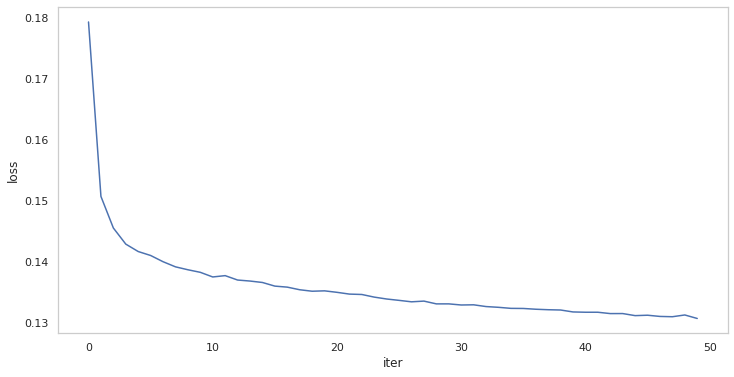

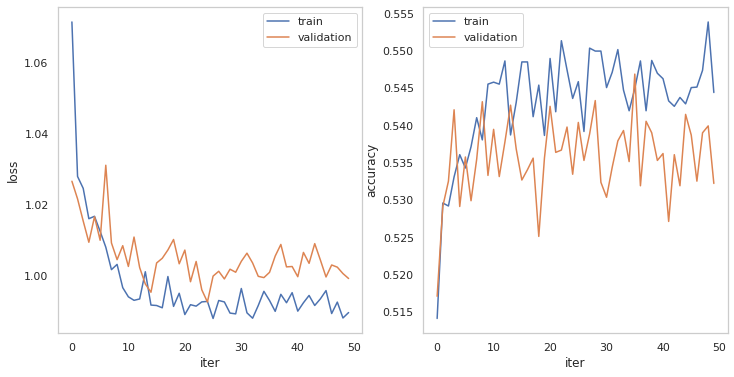

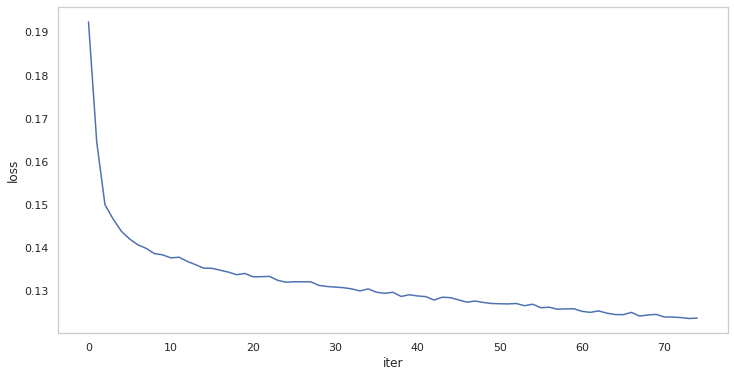

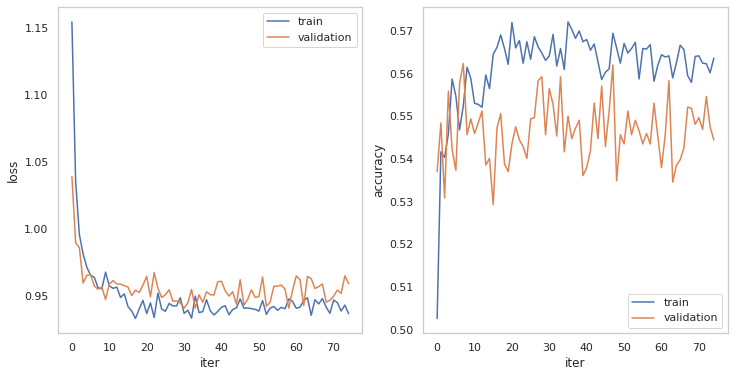

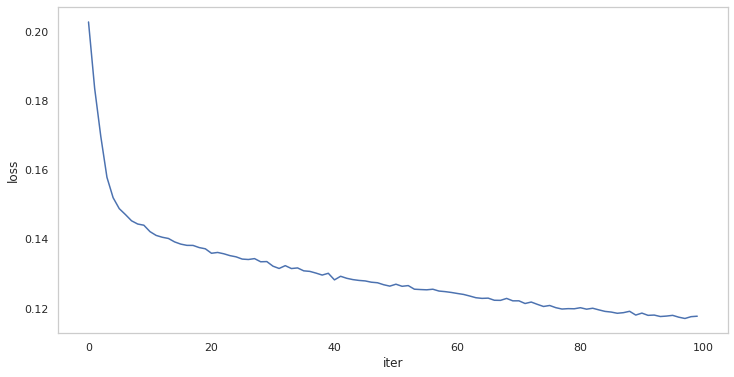

In [12]:
arch = 'GRU'

EMBEDDING_DIM = 256
nums_epochs = [300, 200, 200, 100, 100, 75, 50]
nums_obs = [300, 600, 1300, 2700, 5400, 10800, 21600]
nums_epochs = nums_epochs[::-1]
nums_obs = nums_obs[::-1]
accs = []

for NUM_OBS, NUM_EPOCHS in tqdm(zip(nums_obs, nums_epochs)):
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    print(NUM_OBS, NUM_EPOCHS)
    
    dataset.targets = dataset.targets[:NUM_OBS]
    clfdataset.targets = clfdataset.targets[:NUM_OBS]

    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)
    
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE,
        num_workers=0,
    )

    train_idx, test_idx= train_test_split(
        np.arange(len(clfdataset.targets)),
        test_size=0.3,
        shuffle=True,
        stratify=clfdataset.targets,
        random_state=228
    )

    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(
        clfdataset, batch_size=BATCH_SIZE,
        sampler=train_sampler)
    testloader = torch.utils.data.DataLoader(
        clfdataset, batch_size=BATCH_SIZE,
        sampler=test_sampler)
    
    LR = 0.002
    
    # train decoder
    
    encoder = Encoder(
        numerical_input_dim=num_input_dim,
        cat_vocab_sizes=cat_vocab_sizes,
        cat_embedding_dim=cat_embedding_dim,
        embedding_dim=EMBEDDING_DIM,
    )
    encoder.to(device);
    encoder.train()
    optimizer = optim.Adam(encoder.parameters(), lr=LR)
    
    distance = distances.CosineSimilarity()
    reducer = reducers.ThresholdReducer(low = 0) # basically, returns average
    loss_func = losses.TripletMarginLoss(margin = 0.4, distance = distance, reducer = reducer)
    mining_func = miners.TripletMarginMiner(margin = 0.4, distance = distance, type_of_triplets = "semihard")
    
    train_losses = train_ml_model(
        encoder, NUM_EPOCHS, dataloader, NUM_OF_SUBSEQUENCES,
        mining_func, loss_func, optimizer)
    fig, axs = plt.subplots(figsize=(12, 6))

    plt.plot(train_losses, label='train')
    plt.xlabel('iter')
    plt.ylabel('loss');
    plt.savefig(f'plots/ML_{arch}_{EMBEDDING_DIM}_{NUM_OBS}_{NUM_EPOCHS}.png')
    
    SCHEDULER_EPOCHS = 2
    LR = 0.002
    
    # train classifier decoder
    
    classifier = Classifier(
        numerical_input_dim=num_input_dim,
        cat_vocab_sizes=cat_vocab_sizes,
        cat_embedding_dim=cat_embedding_dim,
        embedding_dim=EMBEDDING_DIM
    )
    classifier.encoder = encoder
    classifier.freeze_encoder()
    classifier.to(device);
    
    optimizer = optim.Adam(classifier.decoder.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        patience=SCHEDULER_EPOCHS,
    )
    
    train_losses, train_accuracy, val_losses, val_accuracy = train_classifier(
        classifier, NUM_EPOCHS, trainloader, testloader,
        optimizer, criterion, scheduler,
        enable_train_mode = lambda: classifier.decoder.train(),
        enable_test_mode = lambda: classifier.decoder.eval(),
    )
    
    fig, axs = plt.subplots(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='validation')
    plt.xlabel('iter')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel('iter')
    plt.ylabel('accuracy');
    plt.plot(train_accuracy, label='train')
    plt.plot(val_accuracy, label='validation')
    plt.legend()

    plt.savefig(f'plots/clfdec_{arch}_{EMBEDDING_DIM}_{NUM_OBS}_{NUM_EPOCHS}.png')
    
    accs.append(val_accuracy[-1])

In [ ]:
arch = 'GRU'

In [ ]:
plt.plot(dims, accs)
plt.xlabel('iter')
plt.xscale('log', base=2)
plt.xticks(dims)
plt.ylabel('accuracy');
plt.savefig(f'plots/clfdec_{arch}_embedding_to_acc_{NUM_OBS}_{NUM_EPOCHS}.png')

In [ ]:
accs

In [ ]:
dims

In [ ]:
dims = [32, 64, 128, 256, 512, 1024, 2048]

accs = [0.5453333258628845,
 0.558555543422699,
 0.558222234249115,
 0.5707777738571167,
 0.5681111216545105,
 0.5681111216545105,
 0.45866668224334717]

In [ ]:
arch = 'GRU'

In [ ]:
sns.set_style("whitegrid")

In [ ]:
# sns.lineplot(x=dims, y=accs)
plt.plot(dims, accs)
plt.scatter(dims, accs)
plt.xlabel('Embedding size')
plt.xscale('log', base=2)
plt.xticks(dims)
plt.ylabel('accuracy');
plt.savefig(f'plots/clfdec_{arch}_embedding_to_acc_{NUM_OBS}_{NUM_EPOCHS}.png')

In [ ]:
encoder.eval();

In [ ]:
embeddings_train = torch.zeros((1, EMBEDDING_DIM))[1:].to(device)

for (sequences, labels) in trainloader:
    with torch.no_grad():
        n, c = sequences[0], sequences[1]
        n = n.to(device)
        c = c.to(device)
        labels = labels.to(device)

        embedding = encoder(n, c)
        
        embeddings_train = torch.cat((embeddings_train, embedding))
        
embeddings_test = torch.zeros((1, EMBEDDING_DIM))[1:].to(device)

for (sequences, labels) in testloader:
    with torch.no_grad():
        n, c = sequences[0], sequences[1]
        n = n.to(device)
        c = c.to(device)
        labels = labels.to(device)

        embedding = encoder(n, c)
        
        embeddings = torch.cat((embeddings_test, embedding))

In [ ]:
embeddings_train = embeddings_train.to('cpu')
embeddings_test = embeddings_test.to('cpu')

In [ ]:
X_train = embeddings_train
X_test = embeddings_test
y_train = targets[train_idx]
y_test = targets[test_idx]

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)

In [ ]:
from catboost import CatBoostClassifier, Pool
from catboost import cv
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=228, stratify=y)

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

In [ ]:
model = CatBoostClassifier(
    iterations=500,
    depth=3,
    learning_rate=0.5,
    verbose=True,
    eval_metric='Accuracy',
    auto_class_weights='Balanced',
    random_state=228,
)

In [ ]:
model.fit(train_pool, eval_set=test_pool)

In [ ]:
train_acc = model.evals_result_['learn']['Accuracy']
valid_acc = model.evals_result_['validation']['Accuracy']

plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='valid')
plt.xlabel('iter')
plt.ylabel('accuracy')
plt.legend();

In [ ]:
sum(np.squeeze(model.predict(X_test)) == y_test) / len(y_test)